# TrashSure | C23-PS018

# Bangkit 2023 H2 - Product-Based Capstone

## 1. Import Required Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf

from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

## 2. Load the Dataset

In [ ]:
# Subdirectories for Training, Testing, and Validation
IMAGES_DIR = './Bangkit Custom Dataset'
train_dir = os.path.join(IMAGES_DIR, 'Train')
test_dir = os.path.join(IMAGES_DIR, 'Test')
val_dir = os.path.join(IMAGES_DIR, 'Validation')

In [ ]:
# List of Subdirectories Corresponding to the Class Labels
class_labels = os.listdir(train_dir)
print(class_labels)

['Paper', 'Metal', 'e-Waste', 'Glass', 'Medical', 'Textiles', 'Plastic']


## 3. Image Data Pre-Processing

In [ ]:
# Resize All the Image into 128x128
IMG_SIZE = 128
new_train_dir = os.path.join(IMAGES_DIR, 'Train128')
new_test_dir = os.path.join(IMAGES_DIR, 'Test128')
new_val_dir = os.path.join(IMAGES_DIR, 'Validation128')

# New directory for the Resized Images
if not os.path.exists(new_train_dir):
    os.mkdir(new_train_dir)
if not os.path.exists(new_test_dir):
    os.mkdir(new_test_dir)
if not os.path.exists(new_val_dir):
    os.mkdir(new_val_dir)

In [ ]:
for label in class_labels:
    if not os.path.exists(os.path.join(new_train_dir, label)):
        os.mkdir(os.path.join(new_train_dir, label))
    if not os.path.exists(os.path.join(new_test_dir, label)):
        os.mkdir(os.path.join(new_test_dir, label))
    if not os.path.exists(os.path.join(new_val_dir, label)):
        os.mkdir(os.path.join(new_val_dir, label))

print(os.listdir(os.path.join(train_dir, label)))

['Plastic7524.jpg', 'Plastic10807.jpg', 'Plastic1155.jpg', 'Plastic9248.jpeg', 'Plastic1633.jpg', 'Plastic7242.jpg', 'Plastic8171.jpg', 'Plastic9618.jpeg', 'Plastic1627.jpg', 'Plastic7256.jpg', 'Plastic8165.jpg', 'Plastic8459.jpeg', 'Plastic7606.jpeg', 'Plastic7530.jpg', 'Plastic10813.jpg', 'Plastic1141.jpg', 'Plastic7518.jpg', 'Plastic1169.jpg', 'Plastic10185.jpg', 'Plastic7743.jpeg', 'Plastic8159.jpg', 'Plastic10191.jpg', 'Plastic6612.jpg', 'Plastic8265.jpeg', 'Plastic11502.jpg', 'Plastic1196.jpg', 'Plastic6821.jpg', 'Plastic7281.jpg', 'Plastic1828.jpg', 'Plastic8635.jpeg', 'Plastic11264.jpg', 'Plastic9474.jpeg', 'Plastic7295.jpg', 'Plastic11270.jpg', 'Plastic9024.jpeg', 'Plastic11516.jpg', 'Plastic1182.jpg', 'Plastic10608.jpg', 'Plastic6835.jpg', 'Plastic10620.jpg', 'Plastic9531.jpeg', 'Plastic12037.jpg', 'Plastic1814.jpg', 'Plastic10146.jpg', 'Plastic9161.jpeg', 'Plastic11258.jpg', 'Plastic1800.jpg', 'Plastic10152.jpg', 'Plastic8320.jpeg', 'Plastic12023.jpg', 'Plastic8770.jpeg', 'P

In [ ]:
def resize_and_save_images(source_dir, target_dir, img_size):
    class_labels = os.listdir(source_dir)

    for label in class_labels:
        label_source_dir = os.path.join(source_dir, label)
        label_target_dir = os.path.join(target_dir, label)
        os.makedirs(label_target_dir, exist_ok=True)

        images = os.listdir(label_source_dir)

        for image in images:
            try:
                img = Image.open(os.path.join(label_source_dir, image))
                img = img.resize((img_size, img_size))
                img = img.convert("RGB")
                img.save(os.path.join(label_target_dir, image))
            except Exception as e:
                print(f"Error processing image: {os.path.join(label_source_dir, image)} - {str(e)}")

resize_and_save_images(train_dir, new_train_dir, IMG_SIZE)
resize_and_save_images(test_dir, new_test_dir, IMG_SIZE)
resize_and_save_images(val_dir, new_val_dir, IMG_SIZE)

/Users/sistemcerdassix/tensorflow-test/env/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error processing image: ./Bangkit Custom Dataset/Train/Paper/Paper5583.jpg - cannot identify image file './Bangkit Custom Dataset/Train/Paper/Paper5583.jpg'
Error processing image: ./Bangkit Custom Dataset/Train/Paper/Paper1453.jpg - cannot identify image file './Bangkit Custom Dataset/Train/Paper/Paper1453.jpg'
Error processing image: ./Bangkit Custom Dataset/Train/e-Waste/eWaste1358.jpg - cannot identify image file './Bangkit Custom Dataset/Train/e-Waste/eWaste1358.jpg'


In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        new_train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        new_test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        new_val_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical')

Found 26375 images belonging to 7 classes.
Found 5325 images belonging to 7 classes.
Found 2583 images belonging to 7 classes.


## 4. Modelling

In [ ]:
# MobileNetV2 Base
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                   include_top=False, weights='imagenet')

# Fine-Tune the Model by adding Fully Connected Layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Add dropout for regularization
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    return model

# Create the Model
model = create_model()
model.compile(optimizer='Adam',
              loss=tf.keras.losses.categorical_crossentropy, metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

Metal device set to: Apple M1


2023-11-08 16:13:38.082735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-08 16:13:38.082755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3

## 5. Training

In [ ]:
# Callback to save Model Weights during Training
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

# Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3, restore_best_weights=True)

# Initialize an empty list to store training history
training_history = []

# Training Loop
for epoch in range(100):  # 100 Epochs
    history = model.fit(train_generator, validation_data=val_generator, epochs=1, callbacks=[checkpoint_callback])
    training_history.append(history.history)

    if early_stopping_callback.stopped_epoch > 0:
        print("Early Stopping Triggered.")
        break

# Save the Training History to a CSV file
history_df = pd.DataFrame(training_history)
history_df.to_csv('model.csv', index=False)

2023-11-08 16:13:39.952643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


825/825 [==============================] - ETA: 0s - loss: 0.9054 - categorical_accuracy: 0.6786

2023-11-08 16:14:33.182029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


825/825 [==============================] - 58s 69ms/step - loss: 0.9054 - categorical_accuracy: 0.6786 - val_loss: 3.5268 - val_categorical_accuracy: 0.4847


/Users/sistemcerdassix/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/825 [========>.....................] - ETA: 34s - loss: 0.1344 - categorical_accuracy: 0.9547

## 6. Evaluation

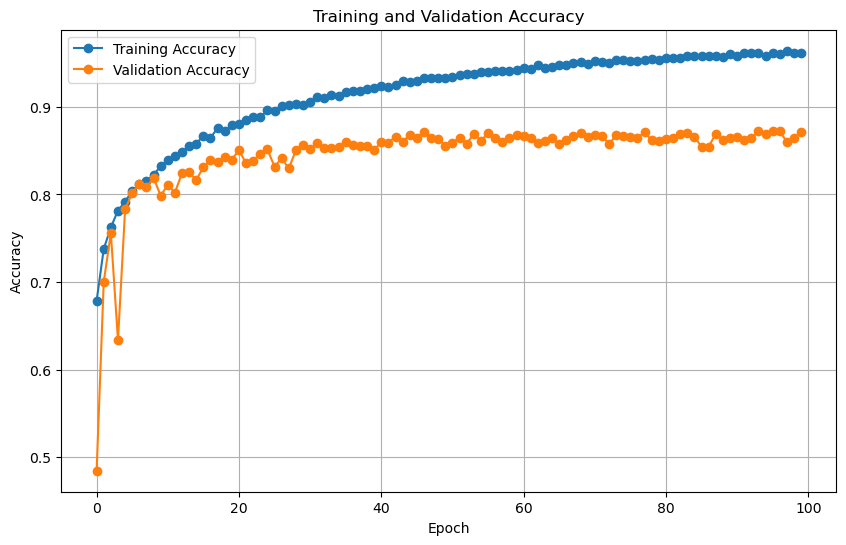

In [ ]:
# Access the Model Training History for Accuracy and Convert from Lists to Numbers
train_accuracy = [float(acc[0]) for acc in history_df['categorical_accuracy']]
val_accuracy = [float(acc[0]) for acc in history_df['val_categorical_accuracy']]

# Plot the Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

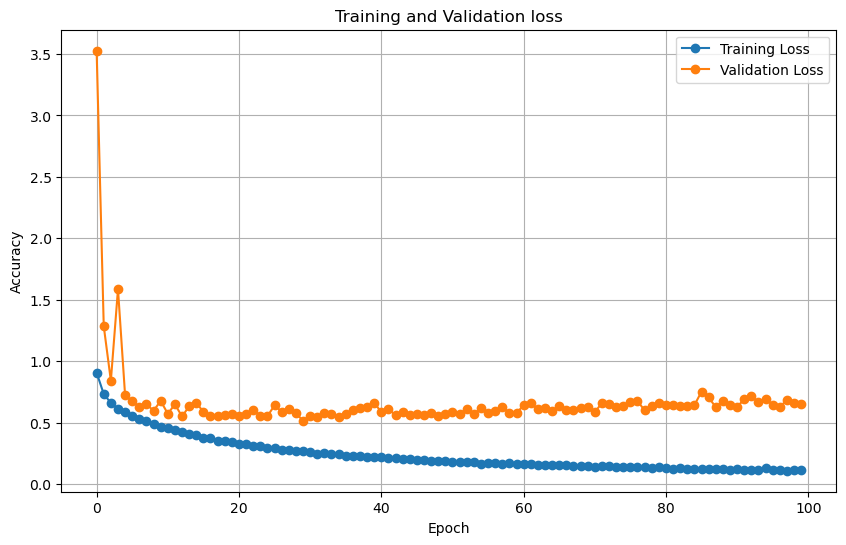

In [ ]:
# Access the Model Training History for Accuracy and Convert from Lists to Numbers
train_loss = [float(acc[0]) for acc in history_df['loss']]
val_loss = [float(acc[0]) for acc in history_df['val_loss']]

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
test_metrics = model.evaluate(test_generator)

test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2023-11-09 09:43:07.574862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 8s 43ms/step - loss: 0.3545 - categorical_accuracy: 0.8969
Test Loss: 0.3544577658176422
Test Accuracy: 0.8969014286994934


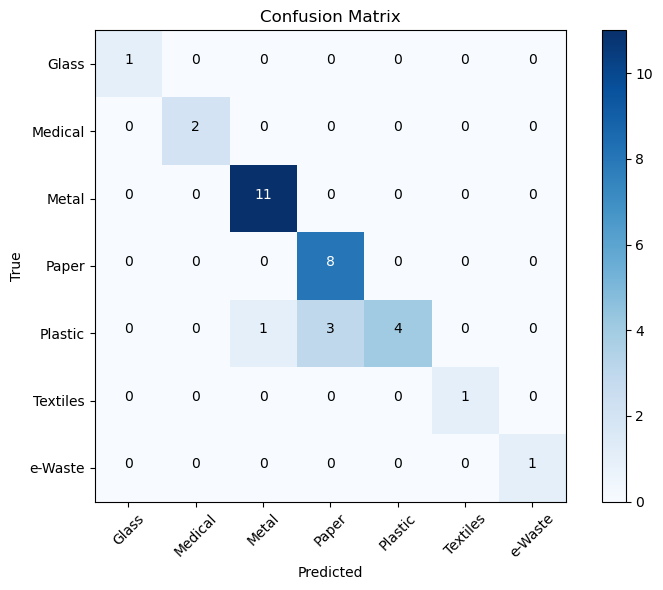

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Define the Class
class_names = ["Glass", "Medical", "Metal", "Paper", "Plastic", "Textiles", "e-Waste"]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

In [ ]:
# Classification Report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       0.92      1.00      0.96        11
           3       0.73      1.00      0.84         8
           4       1.00      0.50      0.67         8
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1

    accuracy                           0.88        32
   macro avg       0.95      0.93      0.92        32
weighted avg       0.90      0.88      0.86        32



## 7. Testing

In [ ]:
print(test_generator.class_indices)

{'Glass': 0, 'Medical': 1, 'Metal': 2, 'Paper': 3, 'Plastic': 4, 'Textiles': 5, 'e-Waste': 6}


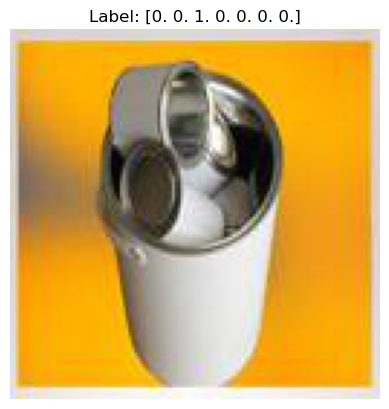

In [ ]:
# Get a batch of images and labels from the test generator
batch = test_generator.next()

# Define the index to access a specific image and label within the batch
index = 0

# Extract the image and its corresponding label
image = batch[0][index]
label = batch[1][index]

# Display the image and label
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

2023-11-09 09:43:23.308825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 482ms/step


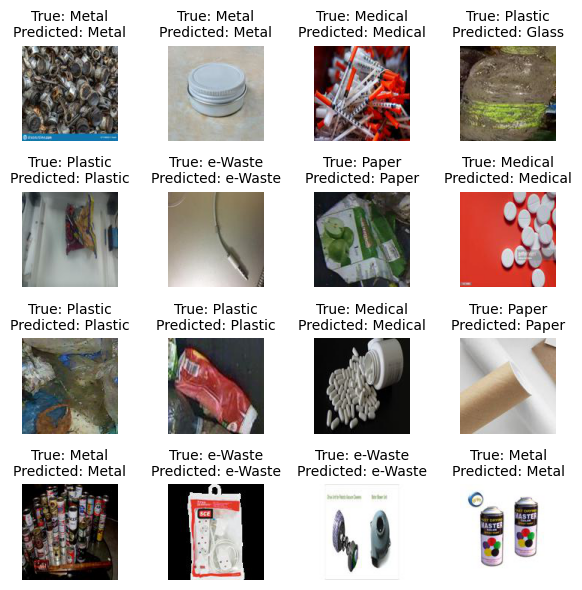

In [ ]:
# Select 16 samples and their true/predicted labels
num_samples = 16
selected_samples = test_generator.next()

# Extract the images and labels from the test batch
images, true_labels = selected_samples[0][:num_samples], selected_samples[1][:num_samples]

# Mapping between numeric labels and class labels
label_mapping = {v: k for k, v in test_generator.class_indices.items()}

# Get predicted labels
predicted_labels = model.predict(images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create a 4x4 grid for image comparison
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])

    # Convert numeric labels to alphanumeric labels
    true_label = label_mapping[np.argmax(true_labels[i])]
    predicted_label = label_mapping[predicted_labels[i]]

    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 28ms/step


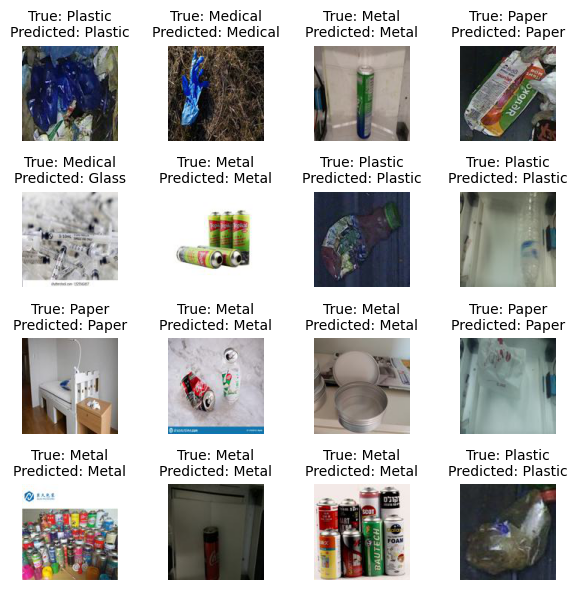

In [ ]:
# Select 16 samples and their true/predicted labels
num_samples = 16
selected_samples = test_generator.next()

# Extract the images and labels from the test batch
images, true_labels = selected_samples[0][:num_samples], selected_samples[1][:num_samples]

# Mapping between numeric labels and class labels
label_mapping = {v: k for k, v in test_generator.class_indices.items()}

# Get predicted labels
predicted_labels = model.predict(images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create a 4x4 grid for image comparison
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])

    # Convert numeric labels to alphanumeric labels
    true_label = label_mapping[np.argmax(true_labels[i])]
    predicted_label = label_mapping[predicted_labels[i]]

    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 29ms/step


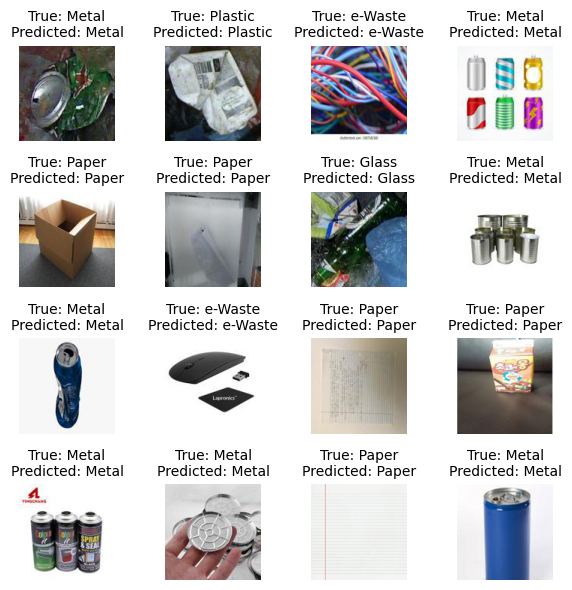

In [ ]:
# Select 16 samples and their true/predicted labels
num_samples = 16
selected_samples = test_generator.next()

# Extract the images and labels from the test batch
images, true_labels = selected_samples[0][:num_samples], selected_samples[1][:num_samples]

# Mapping between numeric labels and class labels
label_mapping = {v: k for k, v in test_generator.class_indices.items()}

# Get predicted labels
predicted_labels = model.predict(images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create a 4x4 grid for image comparison
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])

    # Convert numeric labels to alphanumeric labels
    true_label = label_mapping[np.argmax(true_labels[i])]
    predicted_label = label_mapping[predicted_labels[i]]

    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 27ms/step


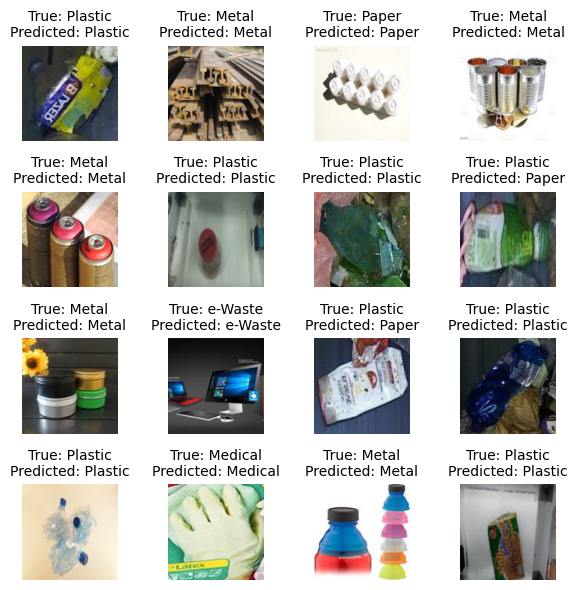

In [ ]:
# Select 16 samples and their true/predicted labels
num_samples = 16
selected_samples = test_generator.next()

# Extract the images and labels from the test batch
images, true_labels = selected_samples[0][:num_samples], selected_samples[1][:num_samples]

# Mapping between numeric labels and class labels
label_mapping = {v: k for k, v in test_generator.class_indices.items()}

# Get predicted labels
predicted_labels = model.predict(images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create a 4x4 grid for image comparison
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])

    # Convert numeric labels to alphanumeric labels
    true_label = label_mapping[np.argmax(true_labels[i])]
    predicted_label = label_mapping[predicted_labels[i]]

    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 42ms/step


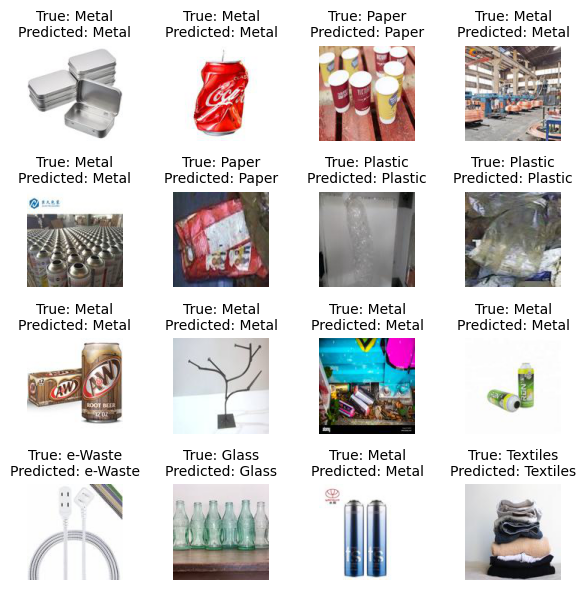

In [ ]:
# Select 16 samples and their true/predicted labels
num_samples = 16
selected_samples = test_generator.next()

# Extract the images and labels from the test batch
images, true_labels = selected_samples[0][:num_samples], selected_samples[1][:num_samples]

# Mapping between numeric labels and class labels
label_mapping = {v: k for k, v in test_generator.class_indices.items()}

# Get predicted labels
predicted_labels = model.predict(images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create a 4x4 grid for image comparison
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])

    # Convert numeric labels to alphanumeric labels
    true_label = label_mapping[np.argmax(true_labels[i])]
    predicted_label = label_mapping[predicted_labels[i]]

    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 8. Convert HDF5 to TF-Lite

In [ ]:
output_directory = './Bangkit - Capstone Project'
os.makedirs(output_directory, exist_ok=True)
tflite_file_path = os.path.join(output_directory, 'model.tflite')

# Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(tflite_file_path, 'wb') as f:
    f.write(tflite_model)

print("Saved the model to:", tflite_file_path)

INFO:tensorflow:Assets written to: /var/folders/p1/ydx02fz94dsd60f311_hhr1h0000gn/T/tmp6bgm1xto/assets


INFO:tensorflow:Assets written to: /var/folders/p1/ydx02fz94dsd60f311_hhr1h0000gn/T/tmp6bgm1xto/assets


Saved the model to: ./Bangkit - Capstone Project/trash-classification_custom100epochs.tflite


2023-11-09 09:58:33.956308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-09 09:58:33.956329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-09 09:58:33.956503: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/p1/ydx02fz94dsd60f311_hhr1h0000gn/T/tmp6bgm1xto
2023-11-09 09:58:33.966578: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-09 09:58:33.966592: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/p1/ydx02fz94dsd60f311_hhr1h0000gn/T/tmp6bgm1xto
2023-11-09 09:58:34.009056: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-09 09:58:34.246442: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /var/folders/p1/ydx02fz94dsd60f311_hhr1h0000gn/T/tmp6bgm1xto
2023-11-